In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display  # 用于在 Jupyter Notebook 中显示图片

# 定义 Amine、Aldehyde 和 Alkyne 的 SMILES
amine_smiles_list = [
    "CN",          # 甲胺 methylamine
    "CCN",         # 乙胺 ethylamine
    "c1ccccc1CN",  # 苄胺 benzylamine
    "c1ccccc1N",   # 苯胺 aniline
    "c1ccccc1CCN", # 苯乙胺 phenethylamine
    "c1ccccc1NC",  # N-甲基苯胺 N-methylaniline
    "NC1=CC=CC=C1",
    "NCCCN1CCN(CCCN)CC1",
    "CNCCCNC",
    "NCCCN1CCCC1",
    "CCNCCNCC"
]

aldehyde_smiles = "C=O"  # 甲醛 formaldehyde

alkyne_smiles_list = [
    "C#CC1=CC=C(CCCC)C=C1",
    "C#CCCCCCCCC"
]

# 定义 Reaction 1 SMARTS：Amine + Aldehyde + Alkyne -> 中间体（接入第一个 propargyl 单元）
rxn1_smarts = '[N;H1,H2:1].[C:2]=[O:3].[C:4]#[C:5] >> [N:1]-[C:2]([C:4]#[C:5])'
# 定义 Reaction 2 SMARTS：在中间体中任一未反应的 N–H 上再接入第二个 propargyl 单元
rxn2_smarts = '[N;H1:10].[C:6]=[O:7].[C:8]#[C:9] >> [N:10]-[C:6]([C:8]#[C:9])'

# 构建反应对象
rxn1 = AllChem.ReactionFromSmarts(rxn1_smarts)
rxn2 = AllChem.ReactionFromSmarts(rxn2_smarts)

# 将 aldehyde 与 alkyne 转换为 RDKit 分子
aldehyde_mol = Chem.MolFromSmiles(aldehyde_smiles)
if aldehyde_mol is None:
    raise ValueError("Aldehyde SMILES 无法解析：{}".format(aldehyde_smiles))

alkyne_mols = [Chem.MolFromSmiles(smi) for smi in alkyne_smiles_list]
alkyne_mols = [mol for mol in alkyne_mols if mol is not None]

final_products = []

# 遍历所有 amine
for amine_smi in amine_smiles_list:
    amine_mol = Chem.MolFromSmiles(amine_smi)
    if amine_mol is None:
        continue

    # Reaction 1: 对每个 amine 与每个 alkyne1（来自同一 alkyne 库）组合进行反应
    for alkyne1 in alkyne_mols:
        reactants1 = (amine_mol, aldehyde_mol, alkyne1)
        products1 = rxn1.RunReactants(reactants1)
        for prod_tuple in products1:
            for prod in prod_tuple:
                try:
                    Chem.SanitizeMol(prod)
                except Exception:
                    continue

                rxn2_applied = False
                # Reaction 2: 对 Reaction 1 生成的中间体，遍历同一 alkyne 库中的所有炔烃
                # 注意：这里 Reaction 2 既可以采用与 Reaction 1 相同的炔烃，也可以采用不同的
                for alkyne2 in alkyne_mols:
                    reactants2 = (prod, aldehyde_mol, alkyne2)
                    products2 = rxn2.RunReactants(reactants2)
                    for prod2_tuple in products2:
                        for prod2 in prod2_tuple:
                            try:
                                Chem.SanitizeMol(prod2)
                                final_products.append(prod2)
                                rxn2_applied = True
                            except Exception:
                                continue
                # 如果 Reaction 2 没有生成产品，则保留 Reaction 1 的产物作为最终产品
                if not rxn2_applied:
                    final_products.append(prod)

# 去除重复产品（基于 SMILES）
unique_smiles = set()
unique_products = []
for mol in final_products:
    smi = Chem.MolToSmiles(mol, isomericSmiles=True)
    if smi not in unique_smiles:
        unique_smiles.add(smi)
        unique_products.append(mol)

# 输出最终产品 SMILES
print("Final products (SMILES):")
for smi in unique_smiles:
    print(smi)

# 使用网格图展示最终产品（每行4个分子，图片大小200x200）
img = Draw.MolsToGridImage(unique_products, molsPerRow=3, subImgSize=(500, 500))

# 在 Jupyter Notebook 中显示图片
display(img)

# 或者保存图片到文件：
# img.save("final_products.png")
# print("图片已保存为 final_products.png")


[10:16:11] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[10:16:11] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 7 
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:12] Explicit valence for atom # 2 C, 5, is greater than permitted
[10:16:12] Explicit valence for atom # 2 C, 5, is greater than permi

Final products (SMILES):
CCCCc1ccc(C#CCN(C)CC#Cc2ccc(CCCC)cc2)cc1
CCCCCCCCC#CCN(C)CC#Cc1ccc(CCCC)cc1
CCCCCCCCC#CCN(C)CC#CCCCCCCCC
CCCCc1ccc(C#CCN(CC)CC#Cc2ccc(CCCC)cc2)cc1
CCCCCCCCC#CCN(CC)CC#Cc1ccc(CCCC)cc1
CCCCCCCCC#CCN(CC)CC#CCCCCCCCC
CCCCc1ccc(C#CCN(CC#Cc2ccc(CCCC)cc2)Cc2ccccc2)cc1
CCCCCCCCC#CCN(CC#Cc1ccc(CCCC)cc1)Cc1ccccc1
CCCCCCCCC#CCN(CC#CCCCCCCCC)Cc1ccccc1
CCCCc1ccc(C#CCN(CC#Cc2ccc(CCCC)cc2)c2ccccc2)cc1
CCCCCCCCC#CCN(CC#Cc1ccc(CCCC)cc1)c1ccccc1
CCCCCCCCC#CCN(CC#CCCCCCCCC)c1ccccc1
CCCCc1ccc(C#CCN(CC#Cc2ccc(CCCC)cc2)CCc2ccccc2)cc1
CCCCCCCCC#CCN(CC#Cc1ccc(CCCC)cc1)CCc1ccccc1
CCCCCCCCC#CCN(CC#CCCCCCCCC)CCc1ccccc1
CCCCc1ccc(C#CCN(C)c2ccccc2)cc1
CCCCCCCCC#CCN(C)c1ccccc1
CCCCc1ccc(C#CCN(CC#Cc2ccc(CCCC)cc2)CCCN2CCN(CCCN)CC2)cc1
CCCCCCCCC#CCN(CC#Cc1ccc(CCCC)cc1)CCCN1CCN(CCCN)CC1
CCCCCCCCC#CCN(CC#CCCCCCCCC)CCCN1CCN(CCCN)CC1
CCCCc1ccc(C#CCN(C)CCCN(C)CC#Cc2ccc(CCCC)cc2)cc1
CCCCCCCCC#CCN(C)CCCN(C)CC#Cc1ccc(CCCC)cc1
CCCCCCCCC#CCN(C)CCCN(C)CC#CCCCCCCCC
CCCCc1ccc(C#CCN(CC#Cc2ccc(CCCC)cc2)CCCN2

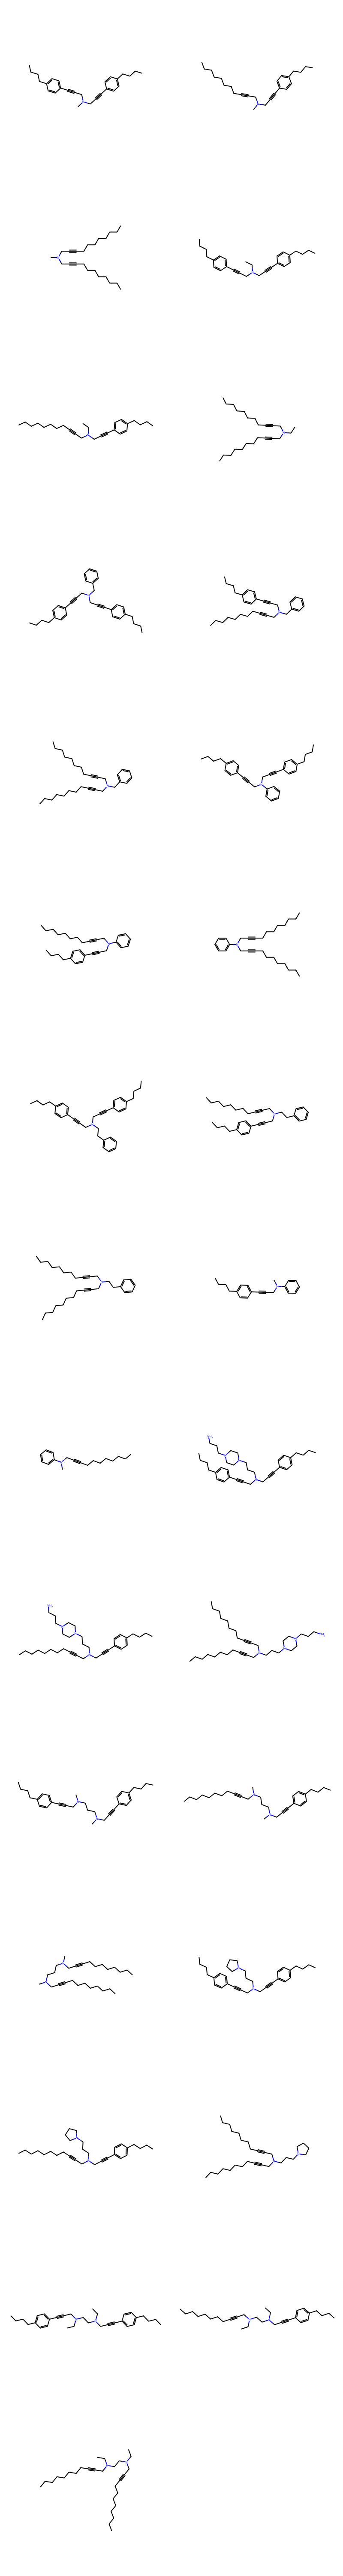

In [11]:
import csv
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display  # 用于在 Jupyter Notebook 中显示图片

# 定义 Amine、Aldehyde 和 Alkyne 的 SMILES
amine_smiles_list = [
    "CN",          # 甲胺 methylamine
    "CCN",         # 乙胺 ethylamine
    "c1ccccc1CN",  # 苄胺 benzylamine
    "c1ccccc1N",   # 苯胺 aniline
    "c1ccccc1CCN", # 苯乙胺 phenethylamine
    "c1ccccc1NC",  # N-甲基苯胺 N-methylaniline
    "NC1=CC=CC=C1",
    "NCCCN1CCN(CCCN)CC1",
    "CNCCCNC",
    "NCCCN1CCCC1",
    "CCNCCNCC"
]

aldehyde_smiles = "C=O"  # 甲醛 formaldehyde

alkyne_smiles_list = [
    "C#CC1=CC=C(CCCC)C=C1",
    "C#CCCCCCCCC"
]

# 定义 Reaction 1 SMARTS：Amine + Aldehyde + Alkyne -> 中间体（接入第一个 propargyl 单元）
rxn1_smarts = '[N;H1,H2:1].[C:2]=[O:3].[C:4]#[C:5] >> [N:1]-[C:2]([C:4]#[C:5])'
# 定义 Reaction 2 SMARTS：在中间体中任一未反应的 N–H 上再接入第二个 propargyl 单元
rxn2_smarts = '[N;H1:10].[C:6]=[O:7].[C:8]#[C:9] >> [N:10]-[C:6]([C:8]#[C:9])'

# 构建反应对象
rxn1 = AllChem.ReactionFromSmarts(rxn1_smarts)
rxn2 = AllChem.ReactionFromSmarts(rxn2_smarts)

# 将 aldehyde 与 alkyne 转换为 RDKit 分子
aldehyde_mol = Chem.MolFromSmiles(aldehyde_smiles)
if aldehyde_mol is None:
    raise ValueError("Aldehyde SMILES 无法解析：{}".format(aldehyde_smiles))

alkyne_mols = [Chem.MolFromSmiles(smi) for smi in alkyne_smiles_list]
alkyne_mols = [mol for mol in alkyne_mols if mol is not None]

final_products = []

# 遍历所有 amine
for amine_smi in amine_smiles_list:
    amine_mol = Chem.MolFromSmiles(amine_smi)
    if amine_mol is None:
        continue

    # Reaction 1: 对每个 amine 与每个 alkyne 组合进行反应（作为 Reaction 1 的 alkyne）
    for alkyne1 in alkyne_mols:
        reactants1 = (amine_mol, aldehyde_mol, alkyne1)
        products1 = rxn1.RunReactants(reactants1)
        for prod_tuple in products1:
            for prod in prod_tuple:
                try:
                    Chem.SanitizeMol(prod)
                except Exception:
                    continue

                rxn2_applied = False
                # Reaction 2: 对 Reaction 1 的中间体，遍历 alkyne 库进行第二步反应
                for alkyne2 in alkyne_mols:
                    reactants2 = (prod, aldehyde_mol, alkyne2)
                    products2 = rxn2.RunReactants(reactants2)
                    for prod2_tuple in products2:
                        for prod2 in prod2_tuple:
                            try:
                                Chem.SanitizeMol(prod2)
                                final_products.append(prod2)
                                rxn2_applied = True
                            except Exception:
                                continue
                # 如果 Reaction 2 没有生成产品，则保留 Reaction 1 的产物作为最终产品
                if not rxn2_applied:
                    final_products.append(prod)

# 去除重复产品（基于 SMILES）
unique_smiles = []
unique_products = []
for mol in final_products:
    smi = Chem.MolToSmiles(mol, isomericSmiles=True)
    if smi not in unique_smiles:
        unique_smiles.append(smi)
        unique_products.append(mol)

# 输出最终产品 SMILES 到控制台
print("Final products (SMILES):")
for smi in unique_smiles:
    print(smi)

# 将最终产品保存到 CSV 文件
csv_filename = "final_products.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["编号", "SMILES"])  # CSV 第一列：编号，第二列：SMILES
    for idx, smi in enumerate(unique_smiles, start=1):
        writer.writerow([idx, smi])
print(f"CSV 文件已保存为 {csv_filename}")

# 使用网格图展示最终产品（每行4个分子，图片大小200x200）
img = Draw.MolsToGridImage(unique_products, molsPerRow=2, subImgSize=(400, 400))
display(img)


In [10]:
rm *csv